# Task 2: Extension of ATHENA

# Introduction

## Transformation as a Weak Defense and Ensemble of many Diverse Weak Defenses
Transformations can be an effective way of deterring some adversarial perturbations. Some transformations are rotation (rotate the input by a certain angle such as 90, 180, and 270 degrees), flip (horizontally and/or vertically), and noise (add noise to the input, such as gaussian). Individually, each weak defense is capable of correctly classifying samples generated by certain methods, but likely to misclassify samples from other methods. For example, the morphology transformation correctly classifies adversarial examples generated by the Fast Gradient Sign Method (FGSM), while rotate(180) misclassifies the same adversaries. One approach to this limitation is the use of an ensemble of many diverse weak defenses (WD): while an adversary can be effective against a a few WD, it is unlikely that it can be effective against a large number of WD that complement each other.

In general terms, a weak defense is created by:

1 - Training: each WD $f_{t_i}$ is trained by applying a transformation, $t_i$, on the original data $D$, and then training a classifier using the transformed data set $D_{t_i}$.

2 - Testing: a transformation $t_i$ is applied to a given input $x$, generating the transformed input $x_{t_i}$, which is then fed to the corresponding WD $f_{t_i}$.

The standard implementation of ATHENA consists of using many diverse weak defenses and a fixed strategy, such as Majority Voting (MV) or Average Output (AVEO), to determine the prediction agreed upon by most WDs.

## Learning-based strategy
Instead of using a fixed strategy to determine the prediction, we aim to build a model that takes the predictions from weak defenses as the training lable and produces the final label for the input image $x$.  

### Create training and test dataset
The first step is to collect the predictions of the weak defense ensemble by running the benign examples through them. This will produce a (10000,10) matrix of outputs. This second dimension of this matrix includes the output probability that the input is each digit (0,1,2,...,9) in the MNIST dataset. We then  created a ML model that uses these probabilities as the training lables. We decided to aslo test how different activation functions could change the accuracy of our model. Finally, we evaluated against our models against a) benign samples (unadulterated images),b) adversarial examples from the weak defenses, and c) the adversarial examples (AEs) generated in Task 1.

#### Utilized weak defenses: list of transformations
Rotate (270 degrees);
Shift (left, bottom right);
Flip (horizontal);
Affine;
Morphology (gradient);
Augmentation (sample-wise std normalization);
Cartoonify (mean);
Quantization (k-mean = 8 clusters);
Distortion (x-axis);
Noise (gaussian, salt & pepper);
Filter (gaussian, rank);
Compress (.jpeg quality 80%);
Denoise (tv chambole);
Geometric (iradon);
Segmentation (gradient radius = 1, median radius = 2).


### Learning ensamble strategy
We implemented three diferent models based on different functions:

#### Rectified linear unit (ReLU) activation function (Jarrett et al., 2009; Nair & Hinton, 2010; Glorot et al., 2011)
The ReLU is half rectified from bottom, meaning that it is defined by the positive part of its argument:

$$f(x)=x^+=max(0,x)$$

or

$$
f(x) = \left\{
    \begin{array}\\
        x\, \text{if}\, x\ >\ 0 \\
        0,\, \text{otherwise.}
    \end{array}
\right.
$$

This function simply preserves positive values and turns all negative values into zero.

#### Exponential Linear Unit (ELU) activation function (Clevert, Unterthiner, & Hochreiter, 2010)
This function is very similiar to RELU except it can have negative values. It also has an extra alpha constant which should be a positive number:
$$
f(x) = \left\{
    \begin{array}\\
        x\, \text{if}\, x\ >\ 0 \\
        \alpha (e^x - 1),\, \text{otherwise.}
    \end{array}
\right.
$$

#### Sigmoid logistic function
Sigmoid functions produce ‘S-shaped’ curves.  The logistic function in particular is symmetric around 0.5:

$$
f(x)=\frac{1}{1+e^{-x}}
$$

### Testing

The AEs we retained from Task 1 are:

#### Attack 1: Fast Gradient Sign Method (FGSM; Goodfellow, Shlens, & Szegedy, 2015)
This method processes adversarial examples as follows:

$$ x' = x + \epsilon \cdot sign(\nabla_xJ(x,y)) $$

where $x'$ is the adversarial image, $J$ is the cost (loss) function of the target model $f$, $\nabla_x$ is the gradient with respect to the input $x$ (original image) with corresponding correct output $y$ (original label), and $\epsilon$ is the magnitude of the perturbation (the change made to the pixels).

Note that the $\epsilon$ parameter is a vector multiplier that ensures the perturbation is small - just large enough to provoke misclassification. We chose values of $\epsilon$ in the range of 0.1 to 1 in increments of 0.1 ($\epsilon$ = 0.1, 0.2, ..., 1.0).

#### Attack 2: Projected Gradient Descent (PGD; Madry, Makelov, Schmidt, Tsipras, & Vladu, 2019)
This is an iterative approach that gradually increases the magnitude of the perturbation until the input is misclassified. Like other methods, it aims to minimize the following worst case loss function over all possible perturbations:

$$\rho(\theta)=E_{(x,y)\sim D}\, \bigg[ \max\limits_{\delta\, \in\, S}L(\theta, x + \delta,y) \bigg]$$

The FGSM described previously approaches is an attack for an $l_\inf$-bounded adversary and generates adversarial examples as seen above. Another adversarial approach is a multi-step variant, which is the *projected gradient descent* (PGD) on the negative loss function

$$ x^{t+1} = \prod_{x+S}(x^t\ +\ \alpha sign(\nabla_x L(\theta,x,y))) $$

For the PGD, we generated attacks in two ways:
1. Manipulating the size of the perturbation, $\epsilon$, from 0.1 to 1 in increments of 0.1 with fixed maximum iteration of 10.
2. Manipulating the number of maximum iterations from 10 to 30 by increments of 2 (10,12,14,...,30) with a fixed $\epsilon$ of 0.3.





# Experimental settings 
We implemented models composed of four layers: an input layer, two fully connected layers with 128 units that are activated on the chosen functions (ReLU, ELU, or sigmoid), and the output layer corresponding to the ten possible classes. The epoch was set to 7 steps for our ML model. 

Our models were evaluated against a) benign samples (unadulterated images),b) adversarial examples from the weak defenses, and c) the adversarial examples (AEs) generated in Task1. 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

### Relu Model evaluation

Text(0, 0.5, 'Adversarial Examples')

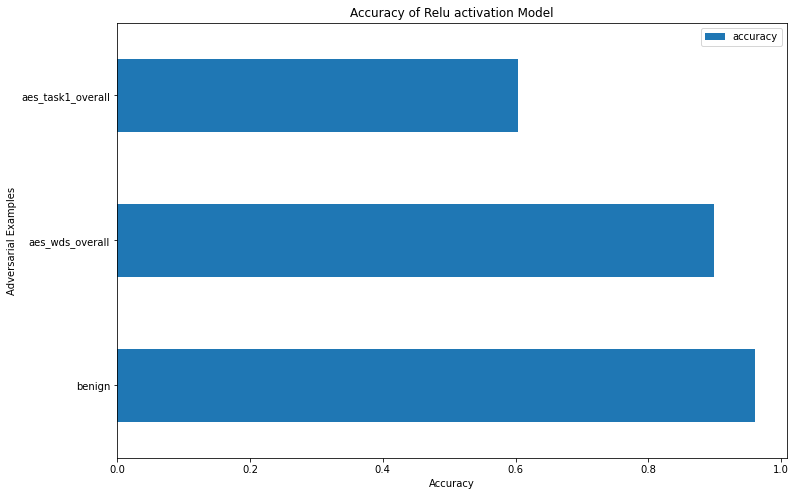

In [12]:
weakd = pd.read_csv("results/Relu_AllAEs.csv")
ax1 = weakd.plot.barh(x='label', y='accuracy',title = 'Accuracy of Relu activation Model')
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Adversarial Examples")


### Elu Model evaluation

Text(0, 0.5, 'Adversarial Examples')

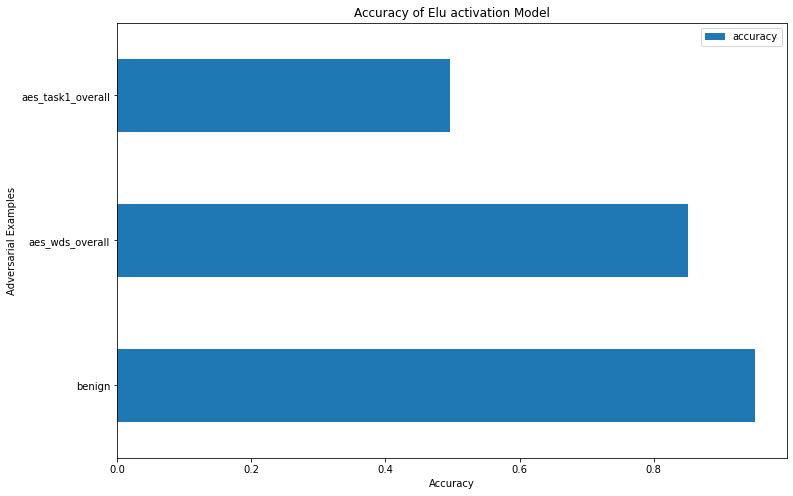

In [11]:
weakd = pd.read_csv("results/Elu_AllAEs.csv")
ax1 = weakd.plot.barh(x='label', y='accuracy',title = 'Accuracy of Elu activation Model')
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Adversarial Examples")

### Sigmoid Model evaluation

Text(0, 0.5, 'Adversarial Examples')

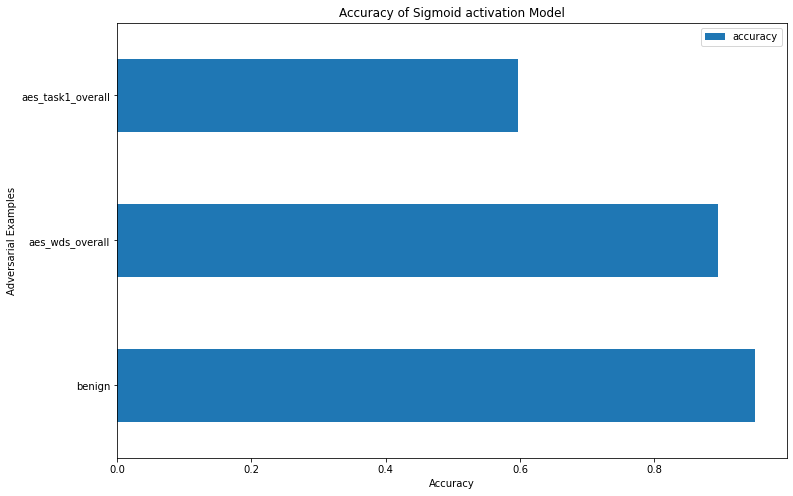

In [8]:
weakd = pd.read_csv("results/Sigmoid_AllAEs.csv")
ax1 = weakd.plot.barh(x='label', y='accuracy',title = 'Accuracy of Sigmoid activation Model')
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Adversarial Examples")

### Accuracy against Individual Ensemble Resuslts (Relu)

Text(0, 0.5, 'Ensemble weak Defense')

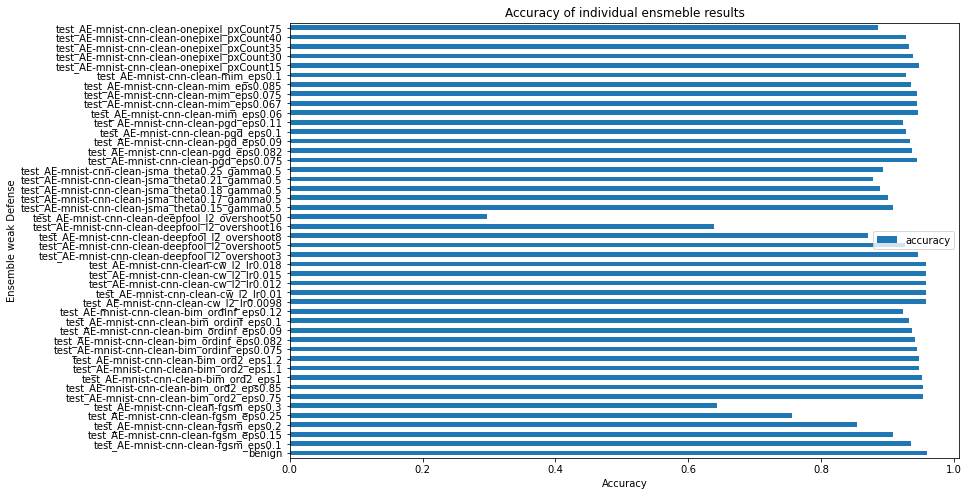

In [15]:
weakd = pd.read_csv("results/EnsembleAEs.csv")
ax1 = weakd.plot.barh(x='label', y='accuracy',title = 'Accuracy of individual ensmeble results')
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Ensemble weak Defense")

### Model evaluated against invividual Task1 PGD AE's and benign examples (Relu)

Text(0, 0.5, "Task1 PGD AE's")

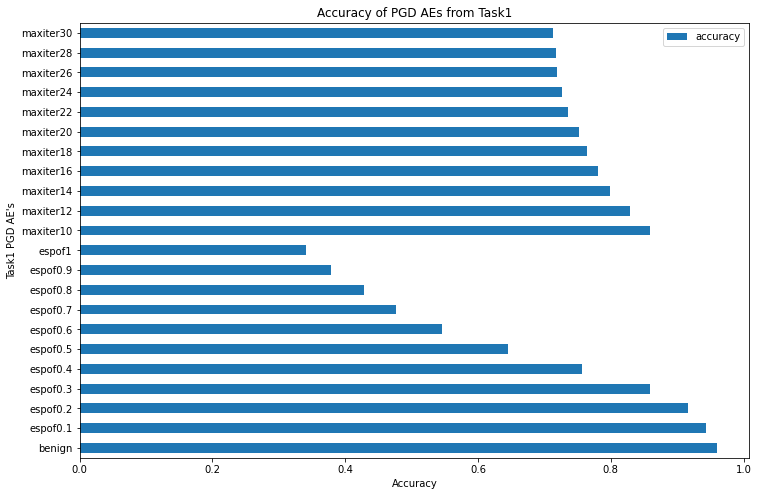

In [16]:
task1PGD = pd.read_csv("results/Task1AEsPGD.csv")
ax2 = task1PGD.plot.barh(x='label', y='accuracy',title = 'Accuracy of PGD AEs from Task1')
ax2.set_xlabel("Accuracy")
ax2.set_ylabel("Task1 PGD AE's")

### Model evaluated against invividual Task1 FGSM AE's and benign examples (Relu)

Text(0, 0.5, "Task1 FGSM AE's")

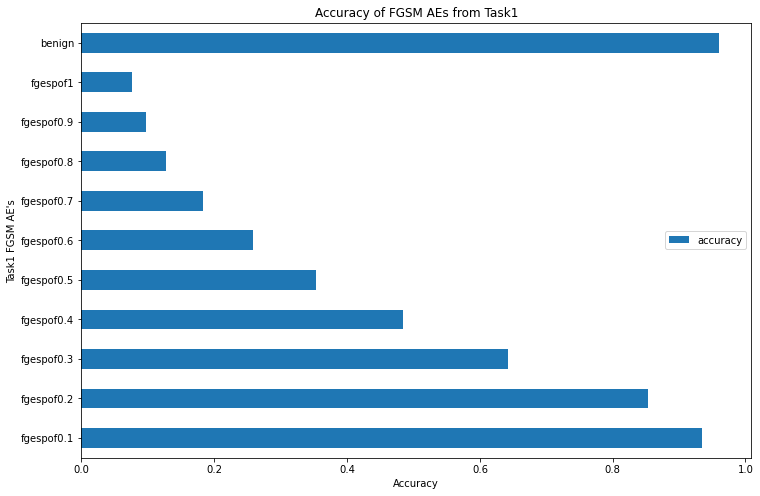

In [18]:
task1FGSM = pd.read_csv("results/Task1AEsFGSM.csv")
ax3 = task1FGSM.plot.barh(x='label', y='accuracy',title = 'Accuracy of FGSM AEs from Task1')
ax3.set_xlabel("Accuracy")
ax3.set_ylabel("Task1 FGSM AE's")

## Discussion 

   We tested our ML model (using predictions of the weak defense ensemble)  built with either Relu, Elu, and Sigmoid activations against benign, weak defense, and Task 1 adversarial examples. The ML model built with Relu activations had the best overall accuracy across all 3 evaluations. Curiously, the ML model built with Sigmoid activations did better than the Elu ML model against the benign examples but faired worse than the Elu model against the wead defense AE's and AE's generated in Task 1.

   Looking closer, our model (Relu version) performs well against most of the weak defense AE's. Against a subset of all Weak defense AE's our model was 90% accurate. Our model however was not as good against our generated AE's from Task 1. The AE's from task 1 were generated by changing pararamaters of PGD and FGSM methods. Our model was not able to correctly guess any of the 31 AE sets but 2 above 90% accuracy. Overall, our model was 60% accurate agains our task 1 outputs. This was expected as our model was trained from predictions of the weak defense ensemble which was not trained by our generated AE's. Our model faired well against benign examples being 96% accurate. 

## Individual Contributions 

# References
Clevert, D.-A., Unterthiner, T., and Hochreiter, S. (2015). Fast and accurate deep network learning
by exponential linear units (elus). arXiv preprint arXiv:1511.07289

Glorot, X., Bordes, A. & Bengio, Y.. (2011). Deep Sparse Rectifier Neural Networks. Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics, in PMLR 15:315-323

Goodfellow, I.J., Shlens, J., & Szegedy, C. (2015). Explaining and Harnessing Adversarial Examples. CoRR, abs/1412.6572.

K. Jarrett, K. Kavukcuoglu, M. Ranzato and Y. LeCun. (2009). "What is the best multi-stage architecture for object recognition?," 2009 IEEE 12th International Conference on Computer Vision, 2146-2153. doi: 10.1109/ICCV.2009.5459469.

Madry, A., Makelov, A., Schmidt, L., Tsipras, D., & Vladu, A. (2018). Towards Deep Learning Models Resistant to Adversarial Attacks. ArXiv, abs/1706.06083.

Nair, Vinod, & Hinto, Geoffrey E.. (2010). Rectified linear units improve restricted boltzmann machines. Proceedings of the 27th International Conference on International Conference on Machine Learning (ICML'10), 807–814.
